In [1]:
device = "mps"


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tqdm as tqdm
from torchmetrics.image.fid import FrechetInceptionDistance
import diffusers
import matplotlib.pyplot as plt


In [9]:
train_dataset = torchvision.datasets.ImageFolder("data/celeba_hq/train", transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((32,32))
]))
test_dataset = torchvision.datasets.ImageFolder("data/celeba_hq/val", transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((32,32))
]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


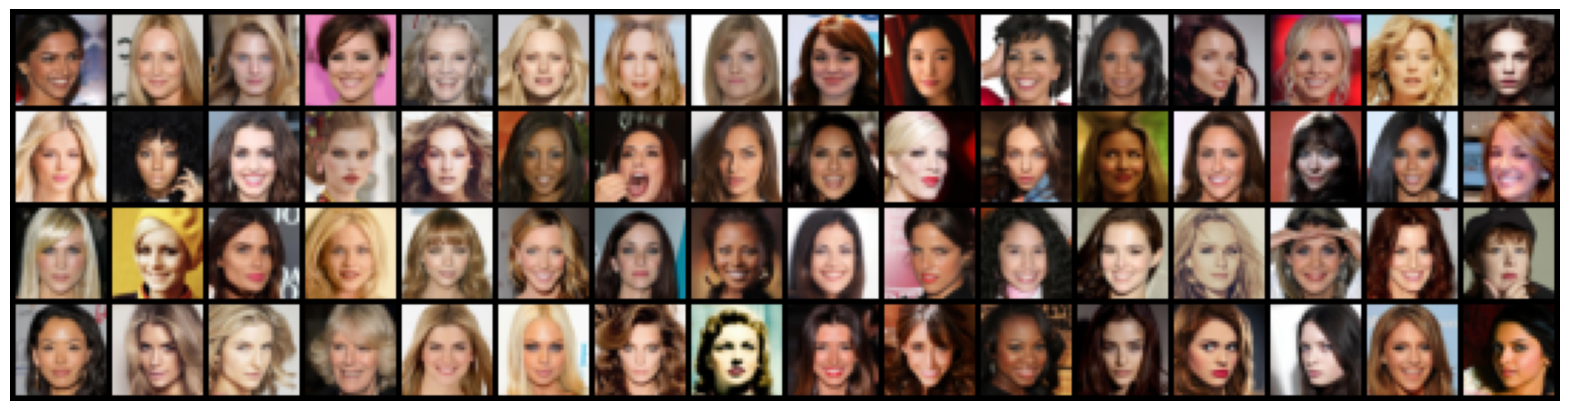

In [10]:
x, y = next(iter(test_loader))

grid = torchvision.utils.make_grid(x, nrow=16)

plt.figure(figsize=(20,20))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()


In [11]:
model = diffusers.UNet2DModel(
    sample_size=(32, 32),
    in_channels=3,
    out_channels=3,
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),  # "DownBlock2D", "AttnDownBlock2D",
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),  # "UpBlock2D", "AttnUpBlock2D",
    block_out_channels=(32, 64, 128, 128),
    layers_per_block=2,
).to(device)

num_train_steps = 0
print(f"Model has {model.num_parameters():,}")


Model has 6,670,019


In [12]:
scheduler = diffusers.DDIMScheduler(
    num_train_timesteps=1000,
    rescale_betas_zero_snr=True
)


In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-5)
criterion = torch.nn.MSELoss()


  0%|          | 0/50 [00:00<?, ?it/s]

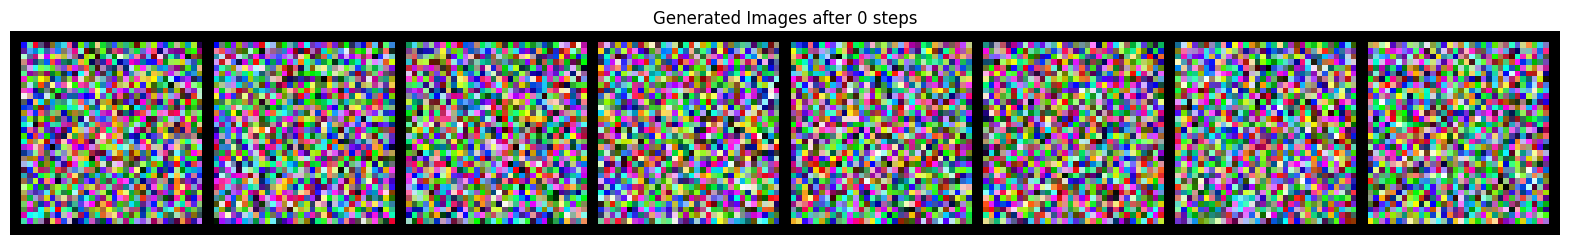

In [15]:
@torch.no_grad()
def generate(batch_size, eta, num_inference_steps):
    pipeline = diffusers.DDIMPipeline(model, scheduler).to(device)

    imgs = pipeline(batch_size, eta=eta, num_inference_steps=num_inference_steps, output_type="np").images
    

    imgs = torch.as_tensor(imgs).permute(0, 3, 1, 2)

    grid = torchvision.utils.make_grid(imgs, normalize=True, nrow=8)

    plt.figure(figsize=(20, 20))
    plt.title(f"Generated Images after {num_train_steps:,} steps")
    plt.font_size = 28
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()


generate(8, 1, 50)


In [ ]:
pbar = tqdm.tqdm(range(10))

for epoch in pbar:
    if num_train_steps > 10000:
            break
    for x, _ in tqdm.tqdm(train_loader, desc="Batches", unit="batches", leave=False):
        x = x.to(device)
        t = torch.randint(0, 1000, (x.size(0),), device=device).long()
        noise = torch.randn_like(x, device=device)

        noisy_x = scheduler.add_noise(x, noise, t)

        pred = model.forward(noisy_x, t).sample

        loss = criterion(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_train_steps += 1

        pbar.set_postfix_str(f"Total Steps: {num_train_steps:,}, Loss: {loss:.4f}")

        if num_train_steps % 1000 == 0:
            generate(16, 1, 50)
            


In [ ]:
#Validation
def validate():
    pbar = tqdm.tqdm(test_loader, desc="Validation", unit="batch", leave=False)
    for x, _ in pbar:
        x = x.to(device)
        t = torch.randint(0, 1000, (x.size(0),), device=device).long()
        noise = torch.randn_like(x, device=device)

        noisy_x = scheduler.add_noise(x, noise, t)

        pred = model.forward(noisy_x, t).sample

        loss = criterion(pred, noise)

        pbar.set_postfix_str(f"Total Steps: {num_train_steps:,}, Loss: {loss:.4f}")

    generate(16, 0, 50)

validate()


In [ ]:
torch.save(model.state_dict(), "projects/paper-implementations/image-generation/7-ddpm/models/mnist1.pth")


In [ ]:
with torch.no_grad():
    fid = FrechetInceptionDistance(feature=2048)
    pipeline = diffusers.DDIMPipeline(model, scheduler).to(device)
    pbar = tqdm.tqdm(test_loader, desc="FID", unit="batch", leave=False)
    
    fids = []
    for i in pbar:
        imgs = pipeline(100, eta=1, num_inference_steps=50, output_type="np").images
        imgs = torch.as_tensor(imgs).permute(0, 3, 1, 2)
        
        x, _ = next(iter(test_loader))
        x = x.to(device)
        
        imgs = F.interpolate(imgs, size=(299, 299), mode="bilinear", align_corners=False)
        x = F.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)
        
        # Convert to UINT8
        imgs = (imgs * 255).clamp(0, 255).to(torch.uint8)
        x = (x * 255).clamp(0, 255).to(torch.uint8)
        
        fid.update(imgs, False)
        fid.update(x, True)
        
        fids.append(fid.compute().item())
        
        pbar.set_postfix_str(f"FID: {fids[-1]:.2f}")
